In [90]:
# Imports for project
#Current MO, copy a project and see if it works just for funsies

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as pylab

from skimage.io import imread
from skimage.color import rgb2gray, label2rgb
from skimage import measure, morphology, exposure
from skimage.measure import regionprops
#from skimage.filters import threshold_otsu
from skimage.morphology import square, dilation, closing

def plot_image(image, title=""):
    pylab.title(title, size=20), pylab.imshow(image)
    pylab.axis("off")

In [91]:
#Get directory for the dataset, this has to be changed based on the name of the folder holding the image dataset
rootdir = '..\SignatureExtraction\Dataset_sig'

#Initialize an array for the images to analyze
docs = []

#Loop through the folder and append files to array
for subdir, _, files in os.walk(rootdir):
    for file in files:
        #There is a .txt file inside of the dataset
        if(file.endswith('.txt')):
            continue
        else:
            docs.append(os.path.join(subdir, file))

#Loop for debugging
#for doc in docs:
#    print(doc)

In [92]:
#Approach 2 for Signature Extraction
#Begin by defining the function where all signature extraction will take place
def signature_extraction(src_im):
    #Check if the input is a numpy array
    im = rgb2gray(src_im)
    
    #Threshold the image to ensure it's in binary
    im_t = cv2.threshold(im, 127, 255, cv2.THRESH_BINARY)[1]
    
    #Attempts to erode and dilate elements using different structures, failed
    """
    #Smaller elements
    structure = cv2.getStructuringElement(cv2.MORPH_CROSS, (2,2))
    eroded = cv2.erode(im_t, structure, iterations = 1)
    structure = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
    dilated = cv2.dilate(eroded, structure, iterations = 1)
    """
    
    
    #Connected component analysis (according to link below)
    #measure.label creates an array of connected areas. If an area is connected then it shares the same integer values
    #https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.label
    blobs_labels = measure.label(im_t, background=0)
        
    #Parameter to control upper outlier range
    parameter_1 = 18
    #Parameter to control percentile range for lower boundary
    percent = 99.5
    
    #This is the method that loops through every connected component and finds the largest one
    #max_component = 0
    total_area = 0
    counter = 0
    average = 0.0
    
    areas = [r.area for r in regionprops(blobs_labels)]
    percentile = np.percentile(sorted(areas), percent)
    #print(string("Percentile: " + str(percentile))
    
    """
    #Method to find total area, used to find average
    for region in regionprops(blobs_labels):
        if (region.area > 10):
            total_area = total_area + region.area
            counter = counter + 1
    
    #This computes the average size of components, another approach
    #average = (total_area/counter)
    """
    
    #Debugging
    #print("the_biggest_component: " + str(max_component))
    #print("average: " + str(average))

    #This represents the threshold for elements too small
    small_outlier = percentile
    
    #This computes the threshold for elements too large
    large_outlier = small_outlier*parameter_1
    #print("large_outlier: " + str(large_outlier))
    
    #This removed the small objects using the previous thresholds
    #https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.remove_small_objects
    #From the list of connected object, anything smaller than the minimum outlier is removed
    pre_version = morphology.remove_small_objects(blobs_labels, small_outlier)
    
    
    #Threshold the image at the end to ensure the output is in binary
    im_t = cv2.threshold(im, 127, 255, cv2.THRESH_BINARY)[1]
    
    #END
    
    
    """
    Inspiration and concepts from:
    @ONLINE{hse,
        author = "Ahmet Özlü",
        title  = "Overlapped handwritten signature extraction from scanned documents",
        year   = "2018",
        url    = "https://github.com/ahmetozlu/signature_extractor"
    }
    """
    
    
    
    return pre_version


In [93]:
from scipy import ndimage as ndi

#This is the signature extraction experimental function
#Begin by defining the function where all signature extraction will take place
def signature_extraction_experimental(src_im):
    #Check if the input is a numpy array
    
    # Step 1: Convert to grayscale
    im = rgb2gray(src_im)
    
    # Step 2: Preprocessing
    img_blur = cv2.medianBlur(im, 5) # Applying median blur
    img_contrast = cv2.equalizeHist(img_blur) # Apply equalization historgram to increase contrast
    
    # define beta to change brightness
    beta = 10 # Brightness control

    # call convertScaleAbs function
    brightened = cv2.convertScaleAbs(img_contrast, beta=beta)
    
    # Step 3: Thresholding using Otsu's method
    _, img_thresh = cv2.threshold(brightened, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # Step 4: Contour Detection
    # FindContours(image, mode, method)
    # mode = Retrieves all contours and puts them into a hierarchy
    # method = Retrieves contrours and stores them as 4 points
    contours, _ = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Check if any contours were found
    if len(contours) == 0:
        print("No contours found. Unable to extract signature.")
        return
    
    #Check the ratio of width to height for each contour
    contours_ratiod = []
    for c in contours:
        _, _, w, h = cv2.boundingRect(c)
        if w > 1.2*h:
            contours_ratiod.append(c)
    
    #contour area gets the area of each contour after ratios were checked
    contour_areas = [cv2.contourArea(c) for c in contours_ratiod]
        
    #Retrieves the largest contour's index
    max_contour_index = np.argmax(contour_areas)
        
    #Stores that contour
    signature_contour = contours_ratiod[max_contour_index]
    
    # Step 5: Bounding Box
    x, y, w, h = cv2.boundingRect(signature_contour)
    bounding_box = cv2.rectangle(im.copy(), (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    # Step 6: Extracting the Signature
    extracted_signature = im.copy()[y:y+h, x:x+w]    
    
    #END TEST
    
    
    return extracted_signature

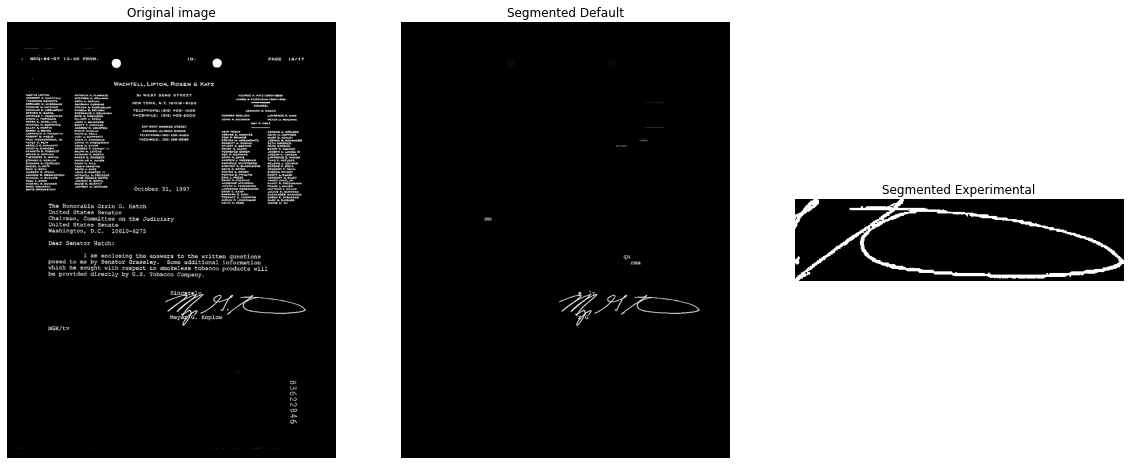

In [94]:
im = imread(docs[0])

im_test = signature_extraction(im)
im_ex = signature_extraction_experimental(im)

fig, (axes1, axes2, axes3) = pylab.subplots(1, 3, figsize=(20, 10))
axes1.axis('off'), axes1.imshow(im, cmap=pylab.cm.gray),
axes1.set_title('Original image')
axes2.axis('off'), axes2.imshow(im_test, cmap=pylab.cm.gray),
axes2.set_title('Segmented Default')
axes3.axis('off'), axes3.imshow(im_ex, cmap=pylab.cm.gray),
axes3.set_title('Segmented Experimental')
pylab.show()

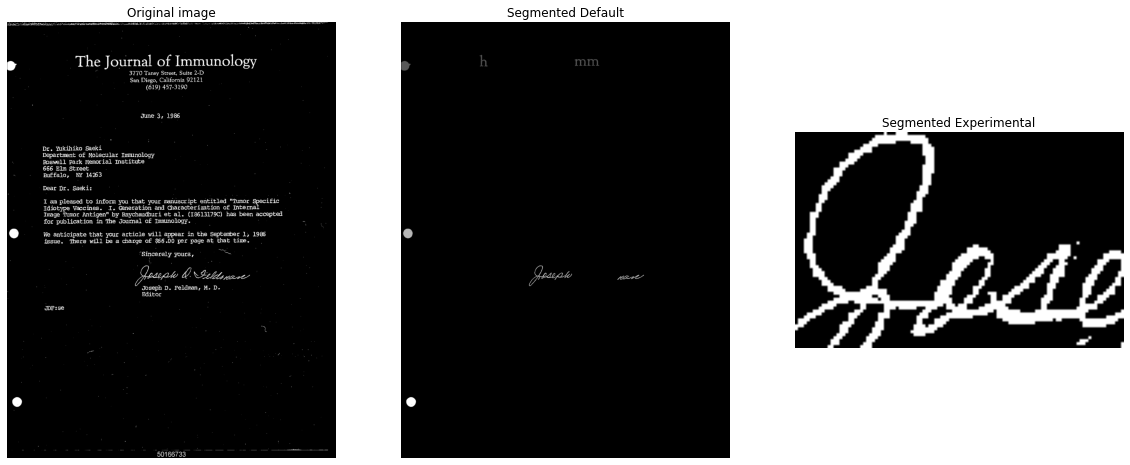

In [95]:
im = imread(docs[1])

im_test = signature_extraction(im)
im_ex = signature_extraction_experimental(im)

fig, (axes1, axes2, axes3) = pylab.subplots(1, 3, figsize=(20, 10))
axes1.axis('off'), axes1.imshow(im, cmap=pylab.cm.gray),
axes1.set_title('Original image')
axes2.axis('off'), axes2.imshow(im_test, cmap=pylab.cm.gray),
axes2.set_title('Segmented Default')
axes3.axis('off'), axes3.imshow(im_ex, cmap=pylab.cm.gray),
axes3.set_title('Segmented Experimental')
pylab.show()

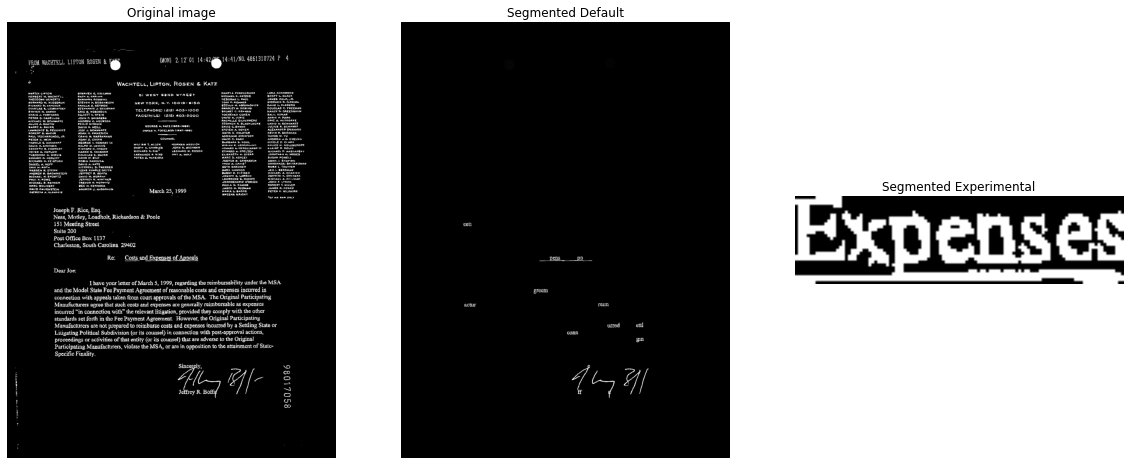

In [96]:
im = imread(docs[2])

im_test = signature_extraction(im)
im_ex = signature_extraction_experimental(im)

fig, (axes1, axes2, axes3) = pylab.subplots(1, 3, figsize=(20, 10))
axes1.axis('off'), axes1.imshow(im, cmap=pylab.cm.gray),
axes1.set_title('Original image')
axes2.axis('off'), axes2.imshow(im_test, cmap=pylab.cm.gray),
axes2.set_title('Segmented Default')
axes3.axis('off'), axes3.imshow(im_ex, cmap=pylab.cm.gray),
axes3.set_title('Segmented Experimental')
pylab.show()

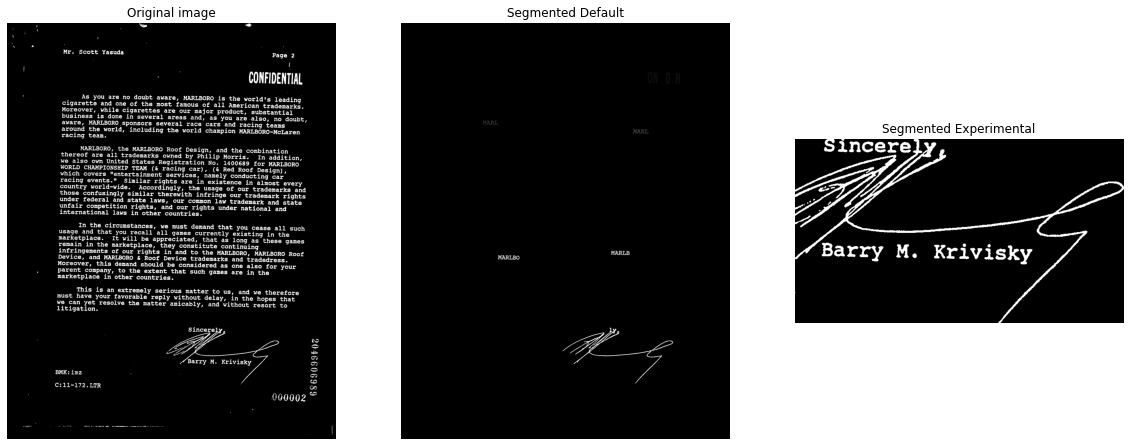

In [97]:
im = imread(docs[3])

im_test = signature_extraction(im)
im_ex = signature_extraction_experimental(im)

fig, (axes1, axes2, axes3) = pylab.subplots(1, 3, figsize=(20, 10))
axes1.axis('off'), axes1.imshow(im, cmap=pylab.cm.gray),
axes1.set_title('Original image')
axes2.axis('off'), axes2.imshow(im_test, cmap=pylab.cm.gray),
axes2.set_title('Segmented Default')
axes3.axis('off'), axes3.imshow(im_ex, cmap=pylab.cm.gray),
axes3.set_title('Segmented Experimental')
pylab.show()

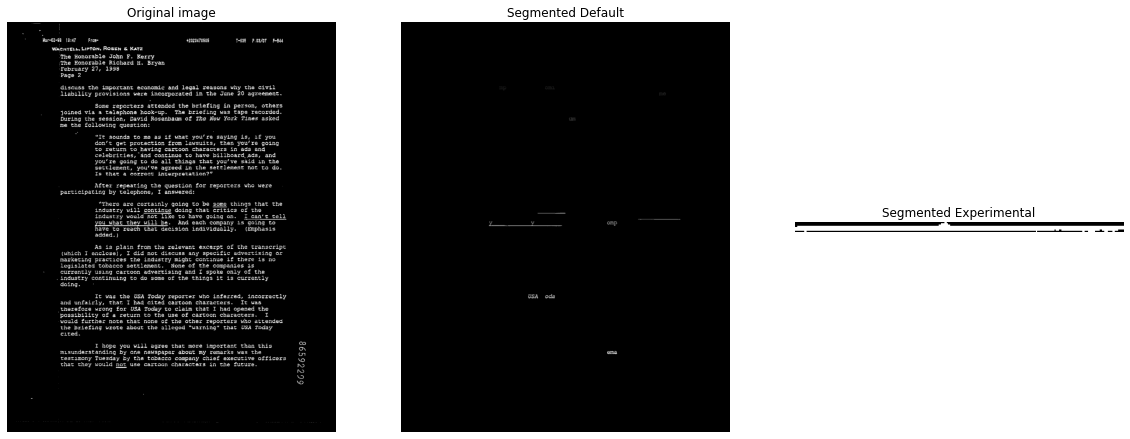

In [98]:
im = imread(docs[4])

im_test = signature_extraction(im)
im_ex = signature_extraction_experimental(im)

fig, (axes1, axes2, axes3) = pylab.subplots(1, 3, figsize=(20, 10))
axes1.axis('off'), axes1.imshow(im, cmap=pylab.cm.gray),
axes1.set_title('Original image')
axes2.axis('off'), axes2.imshow(im_test, cmap=pylab.cm.gray),
axes2.set_title('Segmented Default')
axes3.axis('off'), axes3.imshow(im_ex, cmap=pylab.cm.gray),
axes3.set_title('Segmented Experimental')
pylab.show()

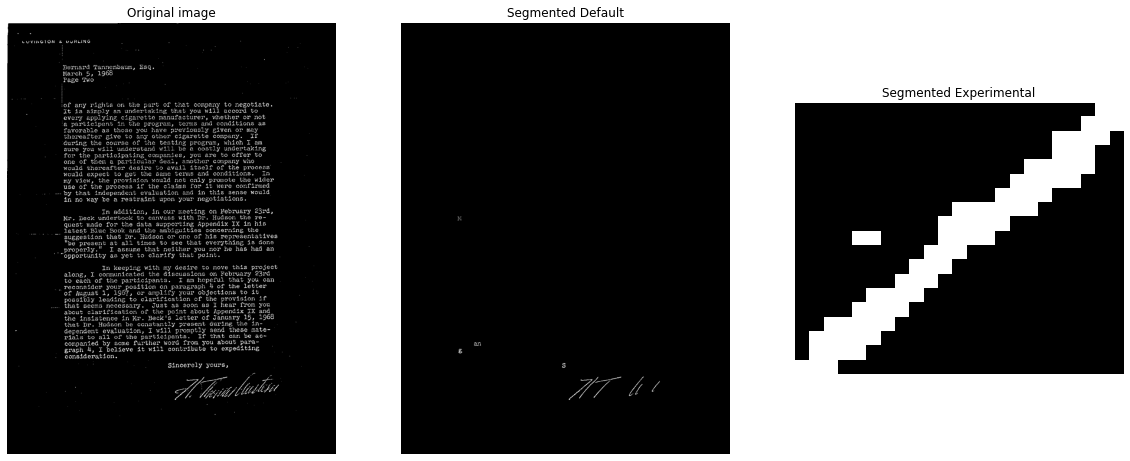

In [99]:
im = imread(docs[5])

im_test = signature_extraction(im)
im_ex = signature_extraction_experimental(im)

fig, (axes1, axes2, axes3) = pylab.subplots(1, 3, figsize=(20, 10))
axes1.axis('off'), axes1.imshow(im, cmap=pylab.cm.gray),
axes1.set_title('Original image')
axes2.axis('off'), axes2.imshow(im_test, cmap=pylab.cm.gray),
axes2.set_title('Segmented Default')
axes3.axis('off'), axes3.imshow(im_ex, cmap=pylab.cm.gray),
axes3.set_title('Segmented Experimental')
pylab.show()

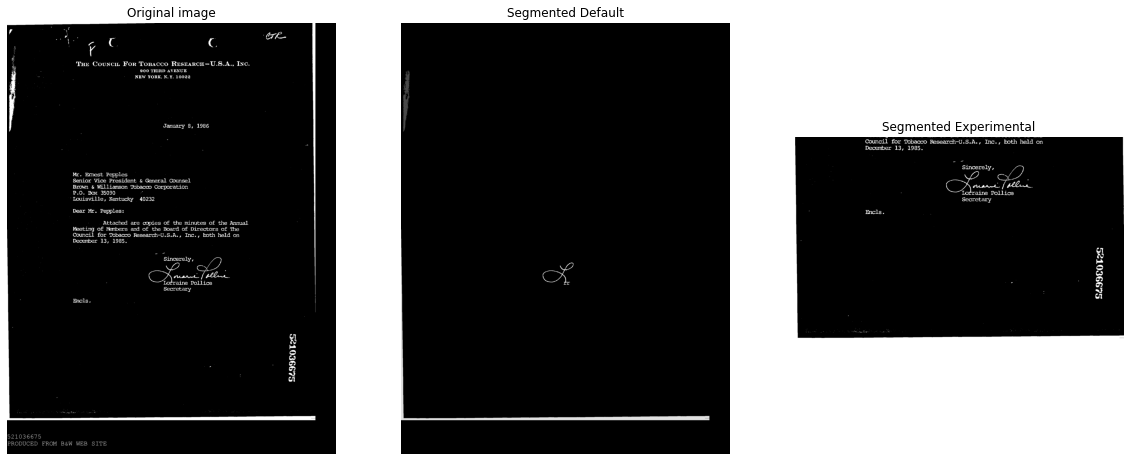

In [100]:
im = imread(docs[6])

im_test = signature_extraction(im)
im_ex = signature_extraction_experimental(im)

fig, (axes1, axes2, axes3) = pylab.subplots(1, 3, figsize=(20, 10))
axes1.axis('off'), axes1.imshow(im, cmap=pylab.cm.gray),
axes1.set_title('Original image')
axes2.axis('off'), axes2.imshow(im_test, cmap=pylab.cm.gray),
axes2.set_title('Segmented Default')
axes3.axis('off'), axes3.imshow(im_ex, cmap=pylab.cm.gray),
axes3.set_title('Segmented Experimental')
pylab.show()

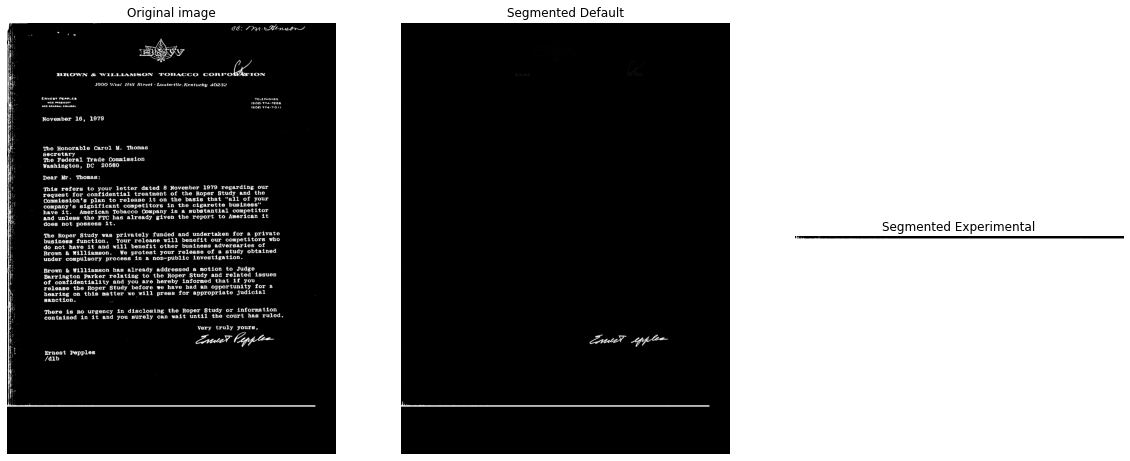

In [101]:
im = imread(docs[7])

im_test = signature_extraction(im)
im_ex = signature_extraction_experimental(im)

fig, (axes1, axes2, axes3) = pylab.subplots(1, 3, figsize=(20, 10))
axes1.axis('off'), axes1.imshow(im, cmap=pylab.cm.gray),
axes1.set_title('Original image')
axes2.axis('off'), axes2.imshow(im_test, cmap=pylab.cm.gray),
axes2.set_title('Segmented Default')
axes3.axis('off'), axes3.imshow(im_ex, cmap=pylab.cm.gray),
axes3.set_title('Segmented Experimental')
pylab.show()

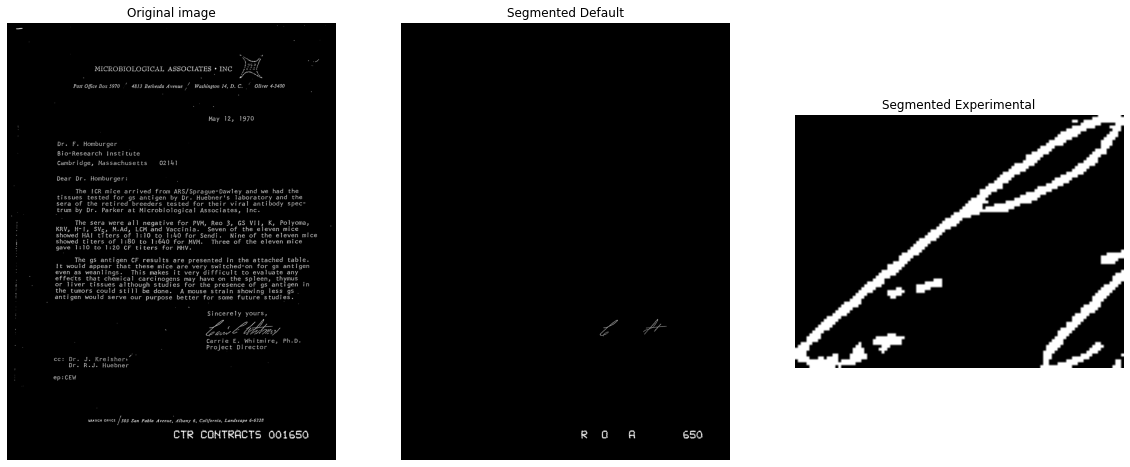

In [102]:
im = imread(docs[8])

im_test = signature_extraction(im)
im_ex = signature_extraction_experimental(im)

fig, (axes1, axes2, axes3) = pylab.subplots(1, 3, figsize=(20, 10))
axes1.axis('off'), axes1.imshow(im, cmap=pylab.cm.gray),
axes1.set_title('Original image')
axes2.axis('off'), axes2.imshow(im_test, cmap=pylab.cm.gray),
axes2.set_title('Segmented Default')
axes3.axis('off'), axes3.imshow(im_ex, cmap=pylab.cm.gray),
axes3.set_title('Segmented Experimental')
pylab.show()

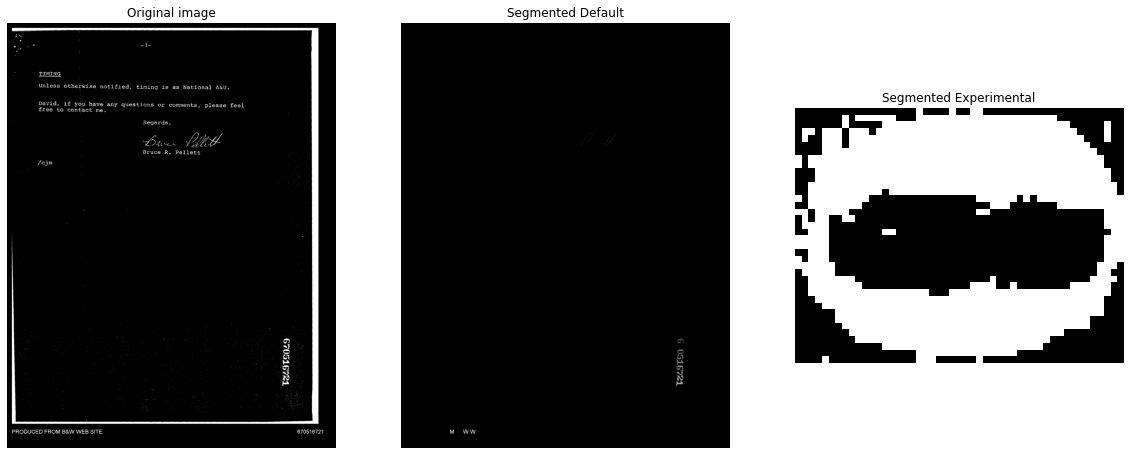

In [103]:
im = imread(docs[9])

im_test = signature_extraction(im)
im_ex = signature_extraction_experimental(im)

fig, (axes1, axes2, axes3) = pylab.subplots(1, 3, figsize=(20, 10))
axes1.axis('off'), axes1.imshow(im, cmap=pylab.cm.gray),
axes1.set_title('Original image')
axes2.axis('off'), axes2.imshow(im_test, cmap=pylab.cm.gray),
axes2.set_title('Segmented Default')
axes3.axis('off'), axes3.imshow(im_ex, cmap=pylab.cm.gray),
axes3.set_title('Segmented Experimental')
pylab.show()

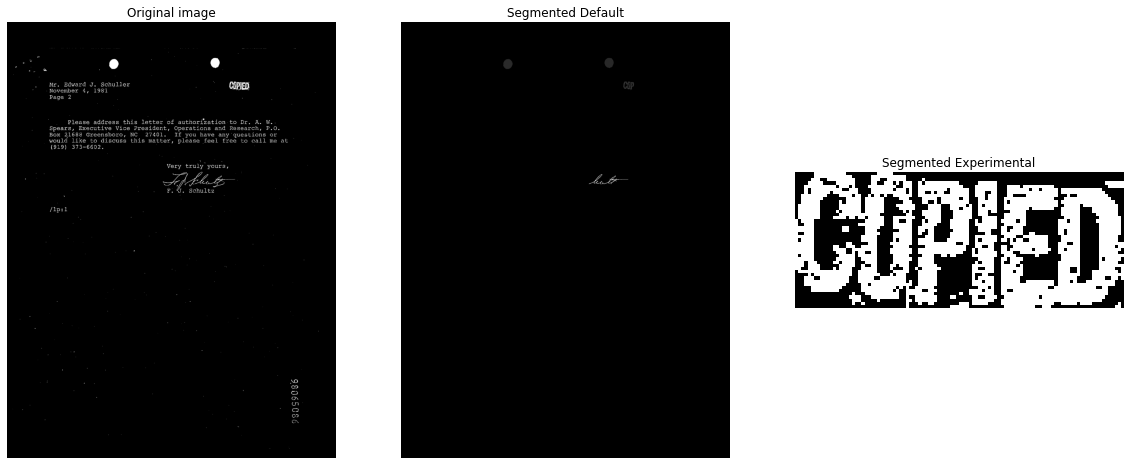

In [104]:
im = imread(docs[10])

im_test = signature_extraction(im)
im_ex = signature_extraction_experimental(im)

fig, (axes1, axes2, axes3) = pylab.subplots(1, 3, figsize=(20, 10))
axes1.axis('off'), axes1.imshow(im, cmap=pylab.cm.gray),
axes1.set_title('Original image')
axes2.axis('off'), axes2.imshow(im_test, cmap=pylab.cm.gray),
axes2.set_title('Segmented Default')
axes3.axis('off'), axes3.imshow(im_ex, cmap=pylab.cm.gray),
axes3.set_title('Segmented Experimental')
pylab.show()

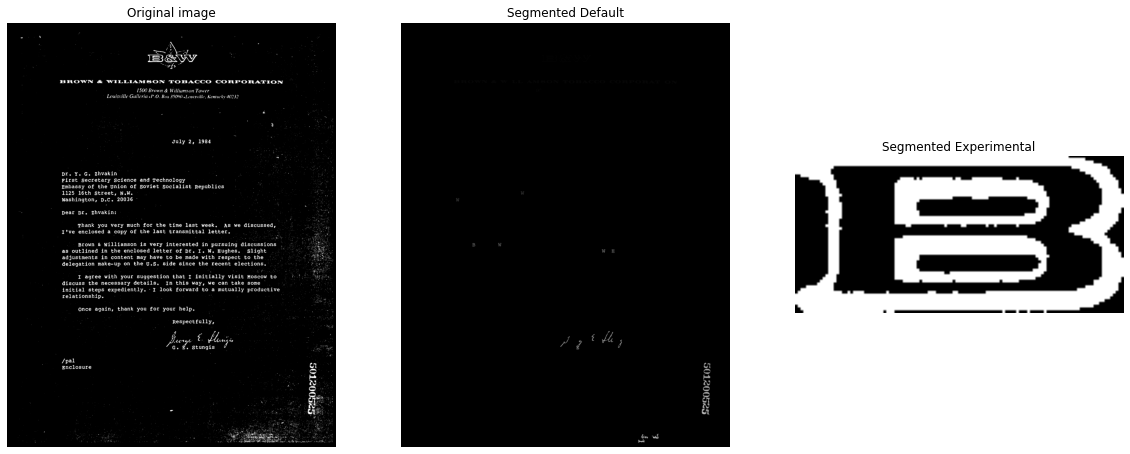

In [105]:
im = imread(docs[11])

im_test = signature_extraction(im)
im_ex = signature_extraction_experimental(im)

fig, (axes1, axes2, axes3) = pylab.subplots(1, 3, figsize=(20, 10))
axes1.axis('off'), axes1.imshow(im, cmap=pylab.cm.gray),
axes1.set_title('Original image')
axes2.axis('off'), axes2.imshow(im_test, cmap=pylab.cm.gray),
axes2.set_title('Segmented Default')
axes3.axis('off'), axes3.imshow(im_ex, cmap=pylab.cm.gray),
axes3.set_title('Segmented Experimental')
pylab.show()

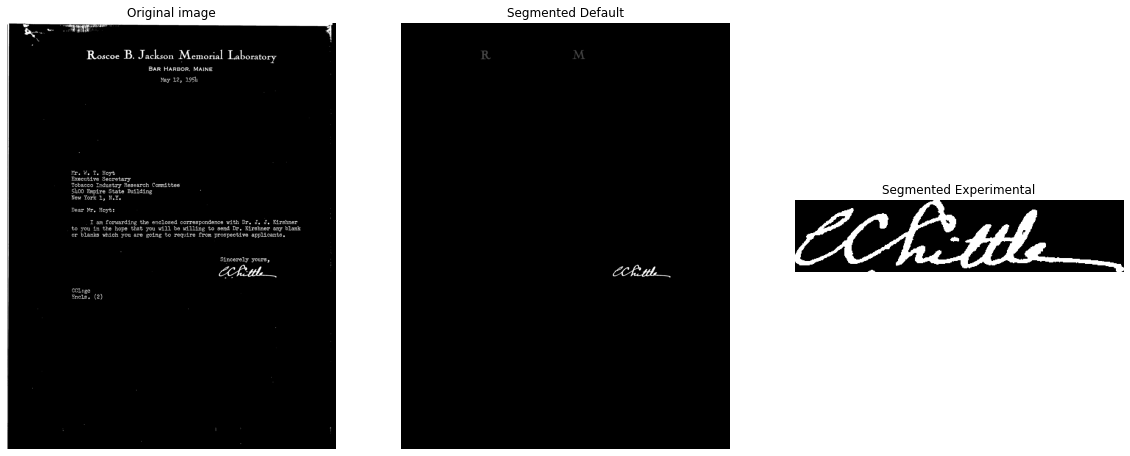

In [106]:
im = imread(docs[12])

im_test = signature_extraction(im)
im_ex = signature_extraction_experimental(im)

fig, (axes1, axes2, axes3) = pylab.subplots(1, 3, figsize=(20, 10))
axes1.axis('off'), axes1.imshow(im, cmap=pylab.cm.gray),
axes1.set_title('Original image')
axes2.axis('off'), axes2.imshow(im_test, cmap=pylab.cm.gray),
axes2.set_title('Segmented Default')
axes3.axis('off'), axes3.imshow(im_ex, cmap=pylab.cm.gray),
axes3.set_title('Segmented Experimental')
pylab.show()

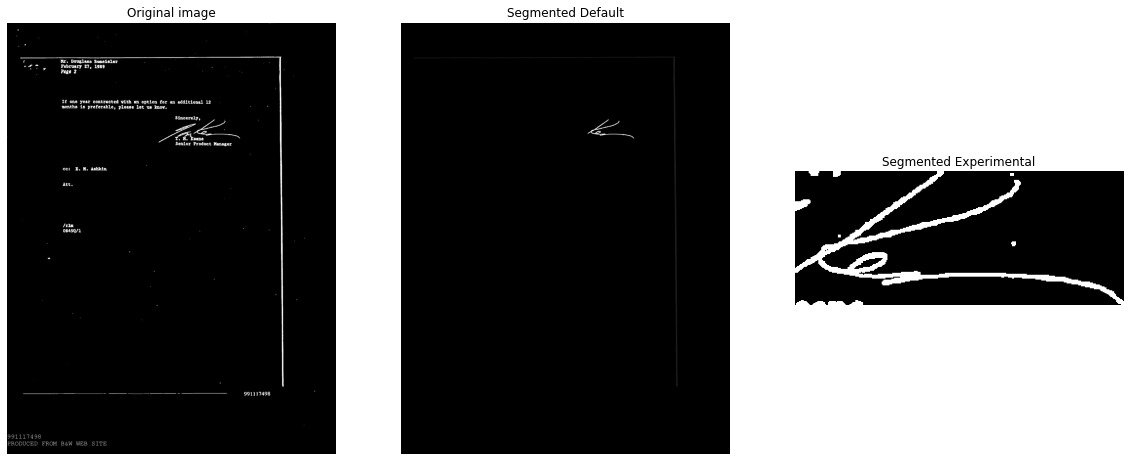

In [107]:
im = imread(docs[13])

im_test = signature_extraction(im)
im_ex = signature_extraction_experimental(im)

fig, (axes1, axes2, axes3) = pylab.subplots(1, 3, figsize=(20, 10))
axes1.axis('off'), axes1.imshow(im, cmap=pylab.cm.gray),
axes1.set_title('Original image')
axes2.axis('off'), axes2.imshow(im_test, cmap=pylab.cm.gray),
axes2.set_title('Segmented Default')
axes3.axis('off'), axes3.imshow(im_ex, cmap=pylab.cm.gray),
axes3.set_title('Segmented Experimental')
pylab.show()

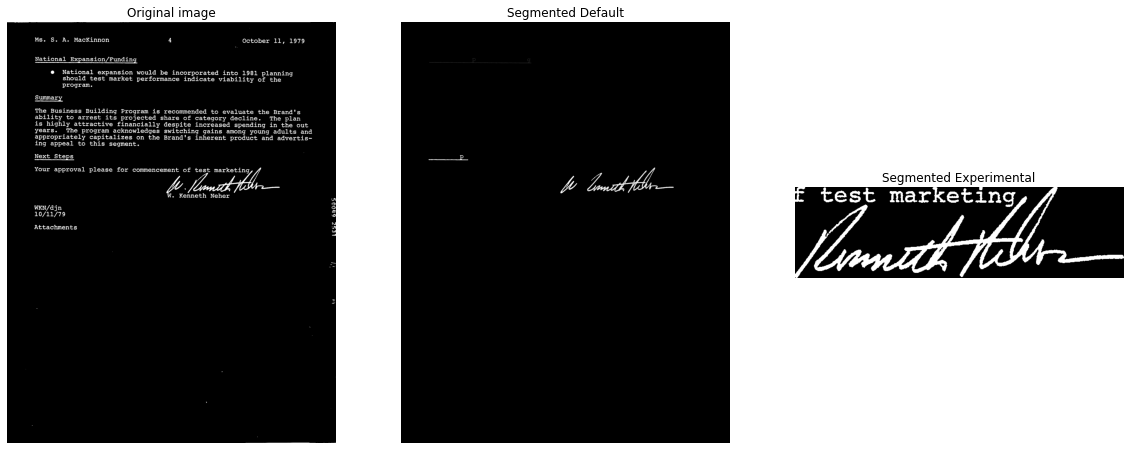

In [108]:
im = imread(docs[14])

im_test = signature_extraction(im)
im_ex = signature_extraction_experimental(im)

fig, (axes1, axes2, axes3) = pylab.subplots(1, 3, figsize=(20, 10))
axes1.axis('off'), axes1.imshow(im, cmap=pylab.cm.gray),
axes1.set_title('Original image')
axes2.axis('off'), axes2.imshow(im_test, cmap=pylab.cm.gray),
axes2.set_title('Segmented Default')
axes3.axis('off'), axes3.imshow(im_ex, cmap=pylab.cm.gray),
axes3.set_title('Segmented Experimental')
pylab.show()

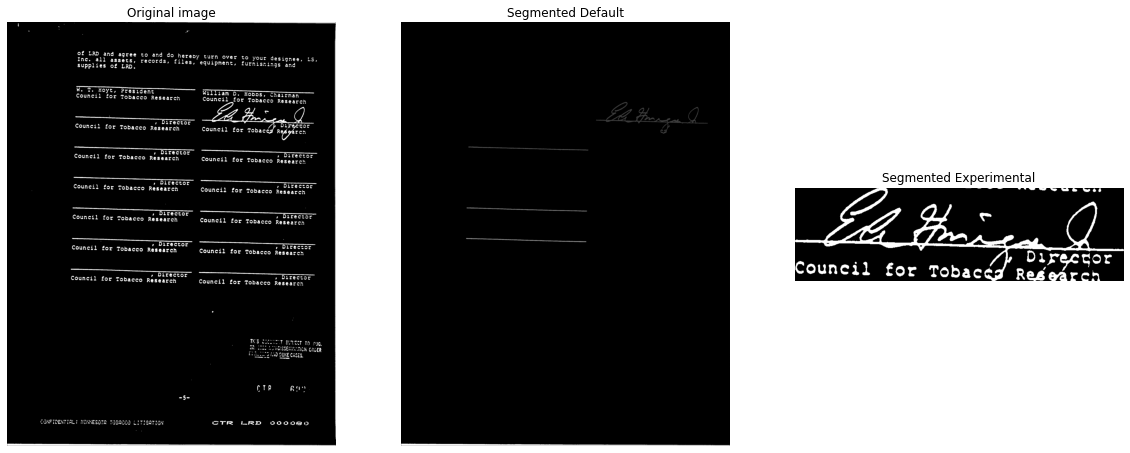

In [109]:
im = imread(docs[15])

im_test = signature_extraction(im)
im_ex = signature_extraction_experimental(im)

fig, (axes1, axes2, axes3) = pylab.subplots(1, 3, figsize=(20, 10))
axes1.axis('off'), axes1.imshow(im, cmap=pylab.cm.gray),
axes1.set_title('Original image')
axes2.axis('off'), axes2.imshow(im_test, cmap=pylab.cm.gray),
axes2.set_title('Segmented Default')
axes3.axis('off'), axes3.imshow(im_ex, cmap=pylab.cm.gray),
axes3.set_title('Segmented Experimental')
pylab.show()

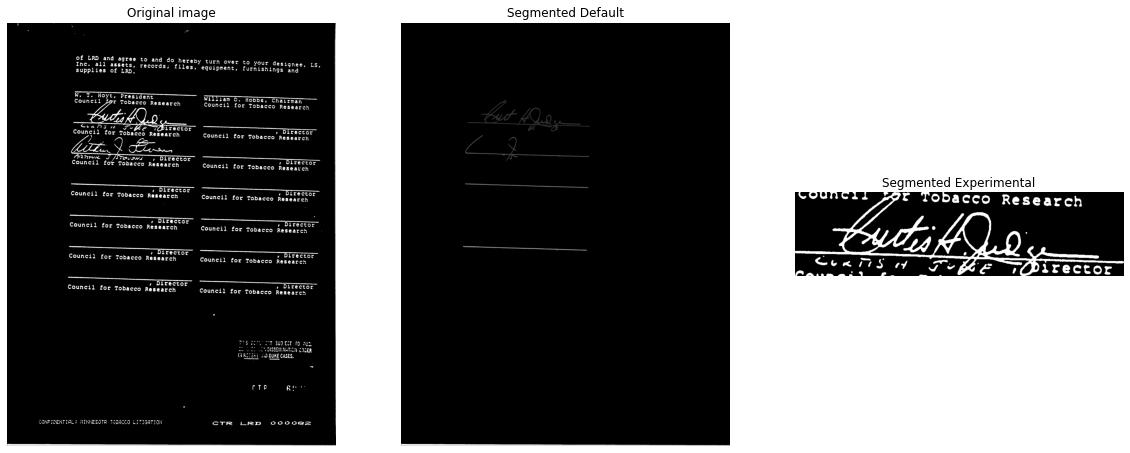

In [110]:
im = imread(docs[16])

im_test = signature_extraction(im)
im_ex = signature_extraction_experimental(im)

fig, (axes1, axes2, axes3) = pylab.subplots(1, 3, figsize=(20, 10))
axes1.axis('off'), axes1.imshow(im, cmap=pylab.cm.gray),
axes1.set_title('Original image')
axes2.axis('off'), axes2.imshow(im_test, cmap=pylab.cm.gray),
axes2.set_title('Segmented Default')
axes3.axis('off'), axes3.imshow(im_ex, cmap=pylab.cm.gray),
axes3.set_title('Segmented Experimental')
pylab.show()

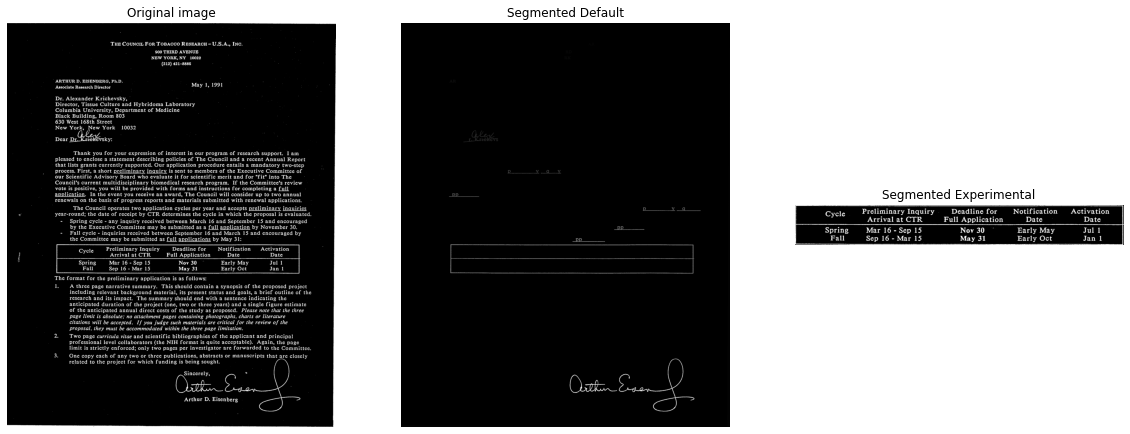

In [111]:
im = imread(docs[17])

im_test = signature_extraction(im)
im_ex = signature_extraction_experimental(im)

fig, (axes1, axes2, axes3) = pylab.subplots(1, 3, figsize=(20, 10))
axes1.axis('off'), axes1.imshow(im, cmap=pylab.cm.gray),
axes1.set_title('Original image')
axes2.axis('off'), axes2.imshow(im_test, cmap=pylab.cm.gray),
axes2.set_title('Segmented Default')
axes3.axis('off'), axes3.imshow(im_ex, cmap=pylab.cm.gray),
axes3.set_title('Segmented Experimental')
pylab.show()

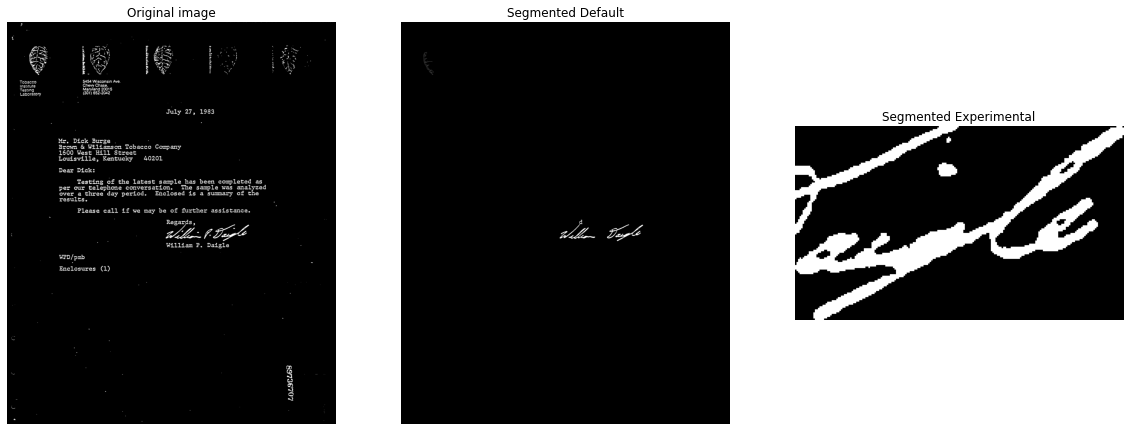

In [112]:
im = imread(docs[18])

im_test = signature_extraction(im)
im_ex = signature_extraction_experimental(im)

fig, (axes1, axes2, axes3) = pylab.subplots(1, 3, figsize=(20, 10))
axes1.axis('off'), axes1.imshow(im, cmap=pylab.cm.gray),
axes1.set_title('Original image')
axes2.axis('off'), axes2.imshow(im_test, cmap=pylab.cm.gray),
axes2.set_title('Segmented Default')
axes3.axis('off'), axes3.imshow(im_ex, cmap=pylab.cm.gray),
axes3.set_title('Segmented Experimental')
pylab.show()

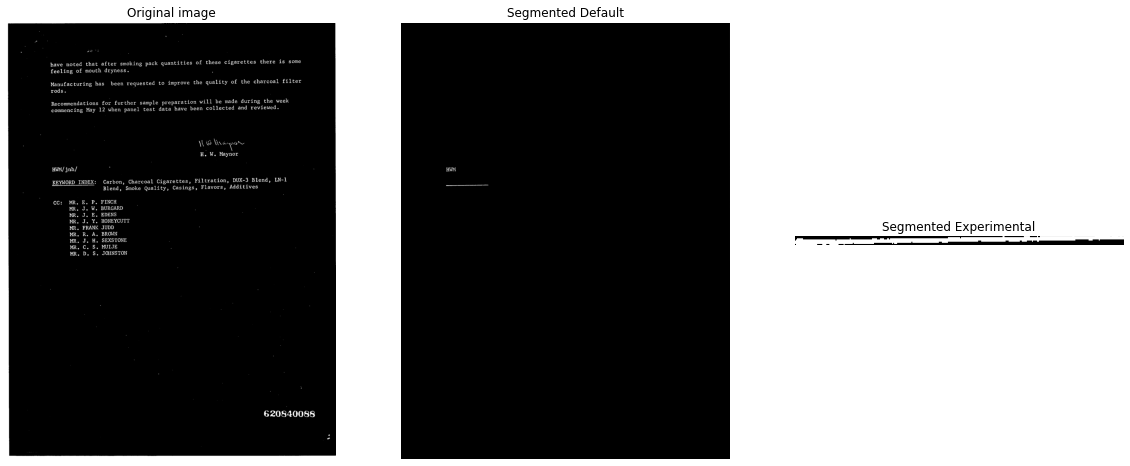

In [113]:
im = imread(docs[19])

im_test = signature_extraction(im)
im_ex = signature_extraction_experimental(im)

fig, (axes1, axes2, axes3) = pylab.subplots(1, 3, figsize=(20, 10))
axes1.axis('off'), axes1.imshow(im, cmap=pylab.cm.gray),
axes1.set_title('Original image')
axes2.axis('off'), axes2.imshow(im_test, cmap=pylab.cm.gray),
axes2.set_title('Segmented Default')
axes3.axis('off'), axes3.imshow(im_ex, cmap=pylab.cm.gray),
axes3.set_title('Segmented Experimental')
pylab.show()

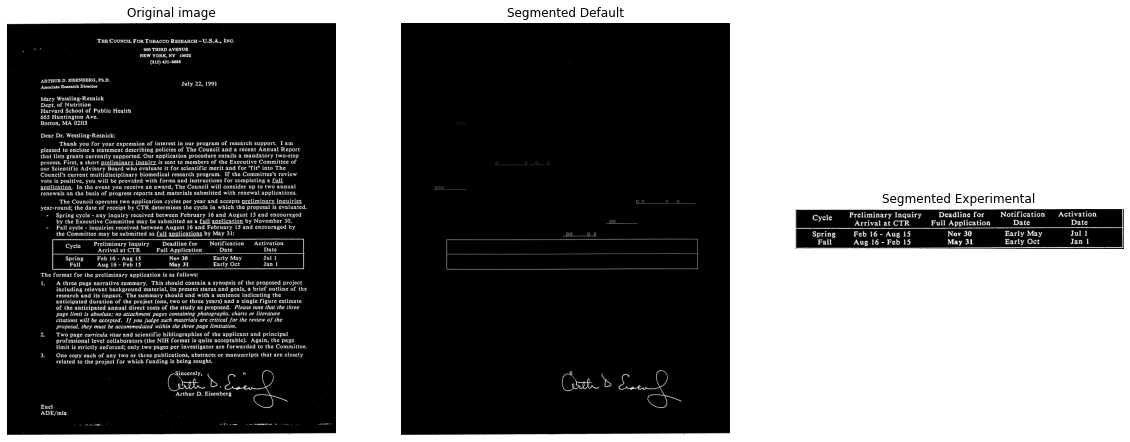

In [114]:
im = imread(docs[20])

im_test = signature_extraction(im)
im_ex = signature_extraction_experimental(im)

fig, (axes1, axes2, axes3) = pylab.subplots(1, 3, figsize=(20, 10))
axes1.axis('off'), axes1.imshow(im, cmap=pylab.cm.gray),
axes1.set_title('Original image')
axes2.axis('off'), axes2.imshow(im_test, cmap=pylab.cm.gray),
axes2.set_title('Segmented Default')
axes3.axis('off'), axes3.imshow(im_ex, cmap=pylab.cm.gray),
axes3.set_title('Segmented Experimental')
pylab.show()

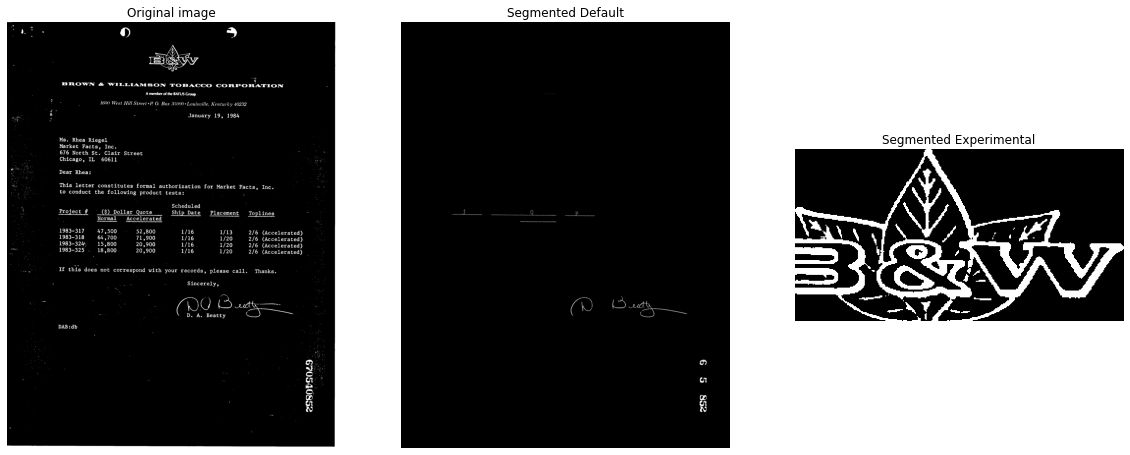

In [115]:
im = imread(docs[21])

im_test = signature_extraction(im)
im_ex = signature_extraction_experimental(im)

fig, (axes1, axes2, axes3) = pylab.subplots(1, 3, figsize=(20, 10))
axes1.axis('off'), axes1.imshow(im, cmap=pylab.cm.gray),
axes1.set_title('Original image')
axes2.axis('off'), axes2.imshow(im_test, cmap=pylab.cm.gray),
axes2.set_title('Segmented Default')
axes3.axis('off'), axes3.imshow(im_ex, cmap=pylab.cm.gray),
axes3.set_title('Segmented Experimental')
pylab.show()

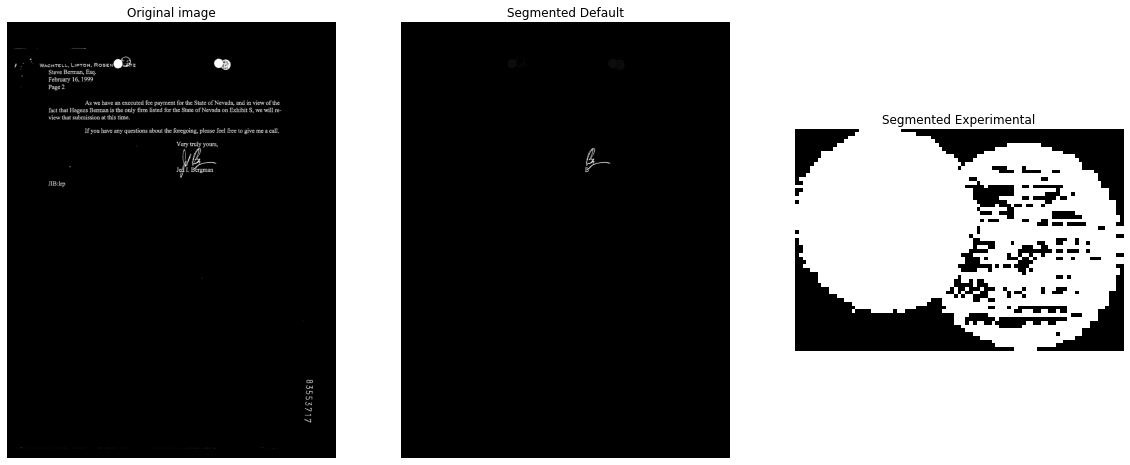

In [116]:
im = imread(docs[22])

im_test = signature_extraction(im)
im_ex = signature_extraction_experimental(im)

fig, (axes1, axes2, axes3) = pylab.subplots(1, 3, figsize=(20, 10))
axes1.axis('off'), axes1.imshow(im, cmap=pylab.cm.gray),
axes1.set_title('Original image')
axes2.axis('off'), axes2.imshow(im_test, cmap=pylab.cm.gray),
axes2.set_title('Segmented Default')
axes3.axis('off'), axes3.imshow(im_ex, cmap=pylab.cm.gray),
axes3.set_title('Segmented Experimental')
pylab.show()

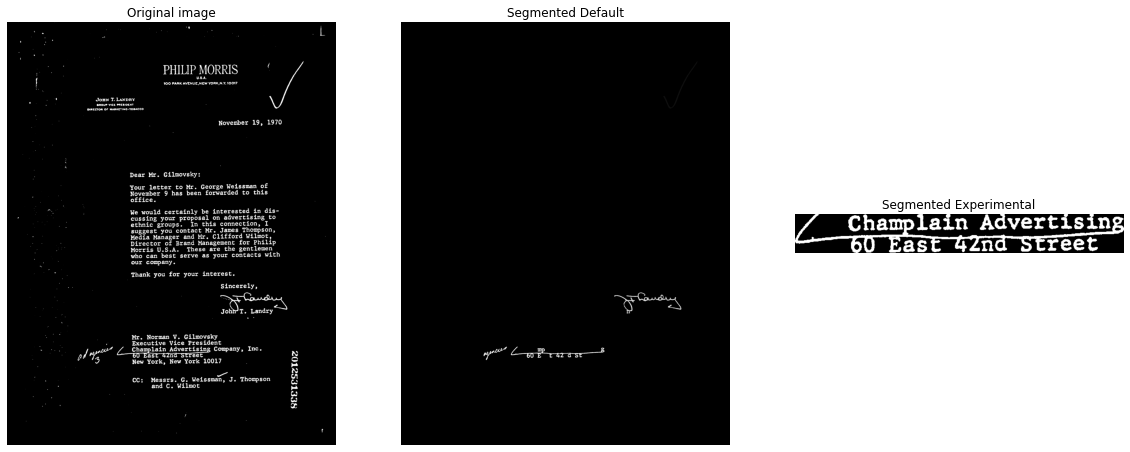

In [117]:
im = imread(docs[23])

im_test = signature_extraction(im)
im_ex = signature_extraction_experimental(im)

fig, (axes1, axes2, axes3) = pylab.subplots(1, 3, figsize=(20, 10))
axes1.axis('off'), axes1.imshow(im, cmap=pylab.cm.gray),
axes1.set_title('Original image')
axes2.axis('off'), axes2.imshow(im_test, cmap=pylab.cm.gray),
axes2.set_title('Segmented Default')
axes3.axis('off'), axes3.imshow(im_ex, cmap=pylab.cm.gray),
axes3.set_title('Segmented Experimental')
pylab.show()